# 문제 1

- 우리 과제는 최동원의 롯데 시절 1983년부터 1988년의 데이터를 사용하도록 하겠습니다. 최동원의 당시 데이터와 함께 1983년부터 1988년 사이 투수들의 데이터(연봉포함)를 구하고, 2015년부터 2020년까지 프로야구의 투수들의 데이터를 구하시오.
-  모든 투수의 데이터를 구하기 어려울 수도 있습니다. 모두 구할 필요는 없습니다. 그러나 선발/마무리에 대해서는 고민하기 바랍니다. 왜냐하면 최동원은 선발로도, 혹은 마무리로도 활동을 했기 때문입니다.

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols

# 시작 전 단계
## 1. 선수의 개인 수상 커리어를 살펴보자

In [2]:
pd.read_csv('../data/개인수상.txt', sep = '\t', encoding = 'cp949')

,연도,KBO MVP,KBO 신인상,KBO 올스타전 MVP,한국시리즈 MVP
0,2020,"로하스(KT,외야수)","소형준(KT,투수)","양의지(NC,포수)","양의지(NC,포수)"
1,2019,"린드블럼(두산,투수)","정우영(LG,투수)","한동민(SK,외야수)","오재일(두산,내야수)"
2,2018,"김재환(두산,외야수)","강백호(KT,외야수)","김하성(넥센,내야수)","한동민(SK,외야수)"
3,2017,"양현종(KIA,투수)","이정후(넥센,내야수)","최정(SK,내야수)","양현종(KIA,투수)"
4,2016,"니퍼트(두산,투수)","신재영(넥센,투수)","민병헌(두산,외야수)","양의지(두산,포수)"
5,2015,"테임즈(NC,내야수)","구자욱(삼성,내야수)","강민호(롯데,포수)","정수빈(두산,외야수)"
6,1987,"장효조(삼성,외야수)","이정훈(빙그레,외야수)","김종모(해태,외야수)","김준환(해태,외야수)"
7,1986,"선동열(해태,투수)","김건우(MBC,투수)","김무종(해태,포수)","김정수(해태,투수)"
8,1985,"김성한(해태,내야수)","이순철(해태,내야수)","김시진(삼성,투수)",해당자 없음
9,1984,"최동원(롯데,투수)","윤석환(OB,투수)","김용희(롯데,내야수)","유두열(롯데,외야수)"


In [3]:
Golden_glove = pd.read_csv('../data/골든글러브.txt', sep = '\t', encoding = 'cp949')
Golden_glove = Golden_glove.iloc[:,:2]
Golden_glove

,연도,투수
0,2020년,알칸타라-두산
1,2019년,린드블럼-두산
2,2018년,린드블럼-두산
3,2017년,양현종-KIA
4,2016년,니퍼트-두산
5,2015년,해커-NC
6,1988년,선동열-해태
7,1987년,김시진-삼성
8,1986년,선동열-해태
9,1985년,김시진-삼성


In [4]:
tmp1 = []
tmp2 = []
for each in Golden_glove['투수']:
    tmp1.append(each.split('-')[0])
    tmp2.append(each.split('-')[1])

In [5]:
Golden_glove['투수'] = tmp1
Golden_glove['팀'] = tmp2

In [6]:
Golden_glove

,연도,투수,팀
0,2020년,알칸타라,두산
1,2019년,린드블럼,두산
2,2018년,린드블럼,두산
3,2017년,양현종,KIA
4,2016년,니퍼트,두산
5,2015년,해커,NC
6,1988년,선동열,해태
7,1987년,김시진,삼성
8,1986년,선동열,해태
9,1985년,김시진,삼성


# 본격적인 데이터 탐구
## 2. 선수의 정규시즌 성적과 연봉을 살펴보자

- 순위 : ERA가 낮은 순으로 정렬

#### 고민해야 될 점
- 1) 그럼 순위는 제거 하고 여러가지 지표들로 연봉을 예측하는 알고리즘을 짤것이냐,
    - 장점 : 통합된 데이터를 통해 한 번에 분석이 용이함
    - 단점 : 년도마다 바뀌는 연봉의 편향을 따라가지 못할 가능성 존재

---

- 2) 순위를 제거하지 않고 년도별로 데이터를 따로 볼것이냐
    - 장점 : 년도 간 연봉차이, 년도마다 바뀌는 연봉의 편향등 고려 가능
    - 단점 : 작년엔 존재했던 투수가 올해에는 존재하지 않는 경우가 존재하며 이를 고려하지 못함

---

우선 1번으로 방향 설정


In [7]:
# 데이터 확인 절차
pd.read_csv('../data/1983.txt', sep = '\t', encoding = 'cp949')

,순위,선수명,팀명,ERA,G,CG,SHO,W,L,SV,...,WPCT,TBF,IP,H,HR,BB,HBP,SO,R,ER
0,1,하기룡,MBC,2.34,36,6,2,10,11,4,...,0.476,696,173 1/3,137,4,48,8,73,57,45
1,2,장명부,삼미,2.36,60,36,6,30,16,6,...,0.652,1712,427 1/3,388,19,106,16,220,138,112
2,3,유종겸,MBC,2.40,34,4,0,8,7,5,...,0.533,560,139,103,8,50,5,74,45,37
3,4,박상열,OB,2.49,30,7,1,10,9,0,...,0.526,716,173 1/3,162,11,44,14,68,57,48
4,5,이길환,MBC,2.51,33,10,4,15,7,4,...,0.682,845,208 1/3,184,8,56,11,85,68,58
5,6,이광권,MBC,2.51,22,3,0,7,5,0,...,0.583,411,100 1/3,96,7,31,4,35,37,28
6,7,김시진,삼성,2.55,37,17,5,17,12,1,...,0.586,950,229 1/3,189,8,95,14,154,78,65
7,8,황태환,OB,2.65,39,0,0,6,6,14,...,0.500,449,105 1/3,105,11,40,5,60,46,31
8,9,이상윤,해태,2.67,46,14,3,20,10,6,...,0.667,944,229 1/3,181,10,95,4,178,83,68
9,10,김용남,해태,2.83,36,6,3,13,10,1,...,0.565,731,181 1/3,171,12,30,5,80,67,57


- 팀명이 중요할까?
    - 팀명을 고려한다면, 그 해 그 팀의 성적과 같이 볼 수 있음
    - 하지만 연봉은 그 팀의 성적과 연관이 없다고 생각
        - why? 같은 팀이지만 연봉차이가 존재 할 수 있기 때문에

- 순위와 팀명은 제거하자

In [8]:
df1983 = pd.read_csv('../data/1983.txt', sep = '\t', encoding = 'cp949')
df1984 = pd.read_csv('../data/1984.txt', sep = '\t', encoding = 'cp949')
df1985 = pd.read_csv('../data/1985.txt', sep = '\t', encoding = 'cp949')
df1986 = pd.read_csv('../data/1986.txt', sep = '\t', encoding = 'cp949')
df1987 = pd.read_csv('../data/1987.txt', sep = '\t', encoding = 'cp949')
#df1988 = pd.read_csv('../data/1988.txt', sep = '\t', encoding = 'cp949')
df2015 = pd.read_csv('../data/2015.txt', sep = '\t', encoding = 'cp949')
df2016 = pd.read_csv('../data/2016.txt', sep = '\t', encoding = 'cp949')
df2017 = pd.read_csv('../data/2017.txt', sep = '\t', encoding = 'cp949')
df2018 = pd.read_csv('../data/2018.txt', sep = '\t', encoding = 'cp949')
df2019 = pd.read_csv('../data/2019.txt', sep = '\t', encoding = 'cp949')
df2020 = pd.read_csv('../data/2020.txt', sep = '\t', encoding = 'cp949')

In [29]:
df1983['년도'] = 1983
df1984['년도'] = 1984
df1985['년도'] = 1985
df1986['년도'] = 1986
df1987['년도'] = 1987
#df1988['년도'] = 1988
df2015['년도'] = 2015
df2016['년도'] = 2016
df2017['년도'] = 2017
df2018['년도'] = 2018
df2019['년도'] = 2019
df2020['년도'] = 2020

#### 연봉 데이터
- http://www.statiz.co.kr/salary.php
- **예전 선수들의 연봉데이터는 존재하지 않음. 따라서, 2015-2021년의 연봉데이터만 우선 이용** 

In [98]:
pay2016 = pd.read_csv('../data/2016연봉.txt', sep="\t", encoding = 'cp949',index_col = 0)
pay2017 = pd.read_csv('../data/2017연봉.txt', sep="\t", encoding = 'cp949',index_col = 0)
pay2018 = pd.read_csv('../data/2018연봉.txt', sep="\t", encoding = 'cp949',index_col = 0)
pay2019 = pd.read_csv('../data/2019연봉.txt', sep="\t", encoding = 'cp949',index_col = 0)
pay2020 = pd.read_csv('../data/2020연봉.txt', sep="\t", encoding = 'cp949',index_col = 0)
pay2021 = pd.read_csv('../data/2021연봉.txt', sep="\t", encoding = 'cp949',index_col = 0)

In [99]:
pay2016.loc['양현종','연봉(만원)']

'75,000'

In [100]:
df_list = [[df2015,pay2016],[df2016,pay2017],[df2017,pay2018],[df2018,pay2019],[df2019,pay2020],[df2020,pay2021]]

In [101]:
for df,pay in df_list:
    df['연봉(다음해)'] = 0
    for idx,row in df.iterrows():
        if row['선수명'] in pay.index:
            df.iloc[idx,-1] = int(pay.loc[row['선수명'],'연봉(만원)'].replace(',',''))

In [112]:
df2020

,순위,선수명,팀명,ERA,G,W,L,SV,HLD,WPCT,...,H,HR,BB,HBP,SO,R,ER,WHIP,년도,연봉(다음해)
0,1,요키시,키움,2.14,27,12,7,0,0,0.632,...,144,6,25,6,115,53,38,1.06,2020,55000
1,2,스트레일리,롯데,2.50,31,15,4,0,0,0.789,...,148,10,51,7,205,61,54,1.02,2020,50000
2,3,브룩스,KIA,2.50,23,11,4,0,0,0.733,...,131,4,24,3,130,43,42,1.02,2020,47900
3,4,알칸타라,두산,2.54,31,20,2,0,0,0.909,...,174,12,30,9,182,58,56,1.03,2020,0
4,5,루친스키,NC,3.05,30,19,5,0,0,0.792,...,173,14,57,11,167,67,62,1.26,2020,100000
5,6,켈리,LG,3.32,28,15,7,0,0,0.682,...,160,16,40,11,134,67,64,1.15,2020,90000
6,7,뷰캐넌,삼성,3.45,27,15,7,0,0,0.682,...,172,16,50,7,121,71,67,1.27,2020,60000
7,8,최채흥,삼성,3.58,26,11,6,0,0,0.647,...,131,12,51,7,123,67,58,1.25,2020,0
8,9,문승원,SK,3.65,25,6,8,0,0,0.429,...,136,13,45,6,117,64,59,1.24,2020,25700
9,10,임찬규,LG,4.08,27,10,9,0,0,0.526,...,143,14,65,5,138,76,67,1.41,2020,0


In [113]:
total_df = pd.concat([df1983,df1984,df1985,df1986,df1987,
                      df2015,df2016,df2017,df2018,df2019,df2020])

In [33]:
total_df.isnull().sum()

순위        0
선수명       0
팀명        0
ERA       0
G         0
CG      128
SHO     128
W         0
L         0
SV        0
HLD       0
WPCT      0
TBF     128
IP        0
H         0
HR        0
BB        0
HBP       0
SO        0
R         0
ER        0
년도        0
WHIP    129
dtype: int64

- 시대별로 집계한 데이터가 달라서 교집합 변수로만 사용해야 할듯 하다.
- ex) CG, SHO, TBF, WHIP는 빼고

In [116]:
total_df.drop(['CG','SHO','TBF','WHIP'], axis = 1, inplace = True)

In [117]:
total_df.drop(['순위','팀명'],axis = 1, inplace = True)
total_df = total_df.reset_index()
del total_df['index']
total_df

,선수명,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,년도,연봉(다음해)
0,하기룡,2.34,36,10,11,4,0,0.476,173 1/3,137,4,48,8,73,57,45,1983,NaN
1,장명부,2.36,60,30,16,6,0,0.652,427 1/3,388,19,106,16,220,138,112,1983,NaN
2,유종겸,2.40,34,8,7,5,0,0.533,139,103,8,50,5,74,45,37,1983,NaN
3,박상열,2.49,30,10,9,0,0,0.526,173 1/3,162,11,44,14,68,57,48,1983,NaN
4,이길환,2.51,33,15,7,4,0,0.682,208 1/3,184,8,56,11,85,68,58,1983,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,양현종,4.70,31,11,10,0,0,0.524,172 1/3,180,13,64,5,149,99,90,2020,0.0
253,박세웅,4.70,28,8,10,0,0,0.444,147 1/3,177,20,47,8,108,85,77,2020,0.0
254,박종훈,4.81,29,13,11,0,0,0.542,157 1/3,146,14,78,22,134,90,84,2020,29000.0
255,서폴드,4.91,28,10,13,0,0,0.435,165,203,19,42,13,97,107,90,2020,0.0


- 연봉이 statiz에는 기재되어있지 않은 선수의 정보가 있나 추가로 확인하고, 검색하여 기록하는 작업을 진행했습니다.

In [287]:
total_df = pd.read_csv('../data/total.csv', sep = ',', encoding = 'cp949', index_col = 0)
total_df

,선수명,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,년도,연봉(다음해)
0,하기룡,2.34,36,10,11,4,0,0.476,173 1/3,137,4,48,8,73,57,45,1983,NaN
1,장명부,2.36,60,30,16,6,0,0.652,427 1/3,388,19,106,16,220,138,112,1983,NaN
2,유종겸,2.40,34,8,7,5,0,0.533,139,103,8,50,5,74,45,37,1983,NaN
3,박상열,2.49,30,10,9,0,0,0.526,173 1/3,162,11,44,14,68,57,48,1983,NaN
4,이길환,2.51,33,15,7,4,0,0.682,208 1/3,184,8,56,11,85,68,58,1983,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,양현종,4.70,31,11,10,0,0,0.524,172 1/3,180,13,64,5,149,99,90,2020,0.0
253,박세웅,4.70,28,8,10,0,0,0.444,147 1/3,177,20,47,8,108,85,77,2020,11000.0
254,박종훈,4.81,29,13,11,0,0,0.542,157 1/3,146,14,78,22,134,90,84,2020,29000.0
255,서폴드,4.91,28,10,13,0,0,0.435,165,203,19,42,13,97,107,90,2020,0.0


- 연봉(다음해)이 0인 선수들은 '년도'에 해당하는 년도에만 선수 생활을하고, 다음시즌에는 kbo에 존재하지 않아 연봉이 기록되지 않은 선수들

- 따라서 제거해야 함

- **하지만 연봉이 NaN인 선수들은 연봉이 집계되지 않은 선수들이라는 점에서 차이가 있다.**
    - 과거 선수들의 연봉 데이터를 찾기 쉽지 않다...
    - (이 부분에 대해서 어떻게 데이터를 수집해야할 지 모르겠습니다.)

# 문제 2
- 사실 가장 중요한 부분인데, 1980년대 최동원이 활동하던 투수들의 연봉 및 데이터를 2010년대 투수들의 연봉 및 데이터로 매핑(mapping) 즉, 변환하는 문제가 있을 것입니다. 이 문제를 효과적으로 해결하시오.
- 즉, 우리는 최동원이 현재 존재한다면 그 연봉을 알고 싶은 것이니, 최동원의 데이터만 현재 선수에 맞춰 변환할 것인지, 혹은, 당시 선수들의 데이터를 모두 변환해서 검토할 것인지 결정해야 할 것입니다.
- 이 문제는 간단하지 않습니다. 그러나 여러분들이 염두해 두어야 할 것은 **`“최동원 선수가 현역 선수라면 연봉이 얼마일까”`**라는 문제를 해결해야 한다는 것입니다.

- 최동원 선수가 현역 선수라면 연봉이 얼마일 것인지 추측하는 알고리즘을 결정하기 위한 전략을 짜보려 합니다.
- 과거 연봉데이터를 구할 수 있다면 더욱 좋겠지만 마땅한 데이터를 찾지 못한 현재의 상황에서 선택할 수 있는 최선의 전략은
- **`현재 존재하는 투수 선수들의 데이터를 토대로 연봉이 얼마인지 학습하고, 그 학습한 모델에 예전 투수들의 데이터를 적합시켜 예측한다.`** 

- 라고 판단하여 그런 방향으로 진행할 것입니다.


- 어쩔 수 없이 2015년이후에 연봉까지 기록된 데이터를 train 데이터로하고, 예전 선수들의 투수 기록들은 test 데이터로 하려고 합니다.


In [288]:
total_df = total_df[total_df['연봉(다음해)'] != 0]
total_df

,선수명,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,년도,연봉(다음해)
0,하기룡,2.34,36,10,11,4,0,0.476,173 1/3,137,4,48,8,73,57,45,1983,NaN
1,장명부,2.36,60,30,16,6,0,0.652,427 1/3,388,19,106,16,220,138,112,1983,NaN
2,유종겸,2.40,34,8,7,5,0,0.533,139,103,8,50,5,74,45,37,1983,NaN
3,박상열,2.49,30,10,9,0,0,0.526,173 1/3,162,11,44,14,68,57,48,1983,NaN
4,이길환,2.51,33,15,7,4,0,0.682,208 1/3,184,8,56,11,85,68,58,1983,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,임찬규,4.08,27,10,9,0,0,0.526,147 2/3,143,14,65,5,138,76,67,2020,13500.0
247,쿠에바스,4.10,27,10,8,0,0,0.556,158,152,16,46,9,110,80,72,2020,60000.0
248,데스파이네,4.33,35,15,8,0,0,0.652,207 2/3,233,18,68,8,152,105,100,2020,45000.0
253,박세웅,4.70,28,8,10,0,0,0.444,147 1/3,177,20,47,8,108,85,77,2020,11000.0


In [302]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 254
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   선수명      228 non-null    object 
 1   ERA      228 non-null    float64
 2   G        228 non-null    int64  
 3   W        228 non-null    int64  
 4   L        228 non-null    int64  
 5   SV       228 non-null    int64  
 6   HLD      228 non-null    int64  
 7   WPCT     228 non-null    float64
 8   IP       228 non-null    object 
 9   H        228 non-null    int64  
 10  HR       228 non-null    int64  
 11  BB       228 non-null    int64  
 12  HBP      228 non-null    int64  
 13  SO       228 non-null    int64  
 14  R        228 non-null    int64  
 15  ER       228 non-null    int64  
 16  년도       228 non-null    int64  
 17  연봉(다음해)  98 non-null     float64
dtypes: float64(3), int64(13), object(2)
memory usage: 41.9+ KB


- IP 변수가 object형임 : why? 이닝수를 나타낼때 1/3이닝 이런식으로 표현하는데, 문자열로 인식하기 때문! 
- ex) 184 1/3  => 184 + 1/3 = 184 + 0.33333.. = 184.33334 이런식으로 변환해줘야 함

In [290]:
# 예시
eval('+'.join('184 1/3'.split(' ')))

184.33333333333334

In [291]:
for idx,row in total_df.iterrows():
    total_df.loc[idx,'IP'] = round(eval('+'.join(row['IP'].split(' '))),2)

total_df

C:\Users\RYU\anaconda3\envs\ds_study\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,선수명,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,년도,연봉(다음해)
0,하기룡,2.34,36,10,11,4,0,0.476,173.33,137,4,48,8,73,57,45,1983,NaN
1,장명부,2.36,60,30,16,6,0,0.652,427.33,388,19,106,16,220,138,112,1983,NaN
2,유종겸,2.40,34,8,7,5,0,0.533,139,103,8,50,5,74,45,37,1983,NaN
3,박상열,2.49,30,10,9,0,0,0.526,173.33,162,11,44,14,68,57,48,1983,NaN
4,이길환,2.51,33,15,7,4,0,0.682,208.33,184,8,56,11,85,68,58,1983,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,임찬규,4.08,27,10,9,0,0,0.526,147.67,143,14,65,5,138,76,67,2020,13500.0
247,쿠에바스,4.10,27,10,8,0,0,0.556,158,152,16,46,9,110,80,72,2020,60000.0
248,데스파이네,4.33,35,15,8,0,0,0.652,207.67,233,18,68,8,152,105,100,2020,45000.0
253,박세웅,4.70,28,8,10,0,0,0.444,147.33,177,20,47,8,108,85,77,2020,11000.0


In [308]:
total_df['IP'] = total_df['IP'].astype('float')

C:\Users\RYU\AppData\Local\Temp/ipykernel_14740/3305625934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['IP'] = total_df['IP'].astype('float')


In [309]:
X_train = total_df[total_df['연봉(다음해)'].notnull()]
#X_train

- train data set이 너무 적다고 생각되긴합니다만, 우선 진행해보려 합니다.
- 아마 전체 투수의 데이터를 이용한것이 아니기에 이렇다고 생각합니다.

In [310]:
X_test = total_df[total_df['연봉(다음해)'].isnull()]
#X_test

- 데이터 입력 과정에서 산체스 선수가 연봉이 0원임에도 NaN으로 기록됨

In [311]:
X_test = X_test.drop([214])
#X_test

In [312]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   선수명      129 non-null    object 
 1   ERA      129 non-null    float64
 2   G        129 non-null    int64  
 3   W        129 non-null    int64  
 4   L        129 non-null    int64  
 5   SV       129 non-null    int64  
 6   HLD      129 non-null    int64  
 7   WPCT     129 non-null    float64
 8   IP       129 non-null    float64
 9   H        129 non-null    int64  
 10  HR       129 non-null    int64  
 11  BB       129 non-null    int64  
 12  HBP      129 non-null    int64  
 13  SO       129 non-null    int64  
 14  R        129 non-null    int64  
 15  ER       129 non-null    int64  
 16  년도       129 non-null    int64  
 17  연봉(다음해)  0 non-null      float64
dtypes: float64(4), int64(13), object(1)
memory usage: 19.1+ KB


In [313]:
X_train.reset_index(inplace = True)
del X_train['index']
X_train

,선수명,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,년도,연봉(다음해)
0,양현종,2.44,32,15,6,0,1,0.714,184.33,150,18,78,7,157,52,50,2015,75000.0
1,해커,3.13,31,19,5,0,0,0.792,204.00,174,14,36,25,164,81,71,2015,60000.0
2,우규민,3.42,25,11,9,0,0,0.550,152.67,163,13,17,12,119,64,58,2015,40000.0
3,린드블럼,3.56,32,13,11,0,0,0.542,210.00,196,28,52,12,180,86,83,2015,120000.0
4,밴헤켄,3.62,32,15,8,0,0,0.652,196.67,190,14,67,1,193,92,79,2015,65000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,임찬규,4.08,27,10,9,0,0,0.526,147.67,143,14,65,5,138,76,67,2020,13500.0
94,쿠에바스,4.10,27,10,8,0,0,0.556,158.00,152,16,46,9,110,80,72,2020,60000.0
95,데스파이네,4.33,35,15,8,0,0,0.652,207.67,233,18,68,8,152,105,100,2020,45000.0
96,박세웅,4.70,28,8,10,0,0,0.444,147.33,177,20,47,8,108,85,77,2020,11000.0


In [315]:
X_test.reset_index(inplace = True)
del X_test['index']
X_test

,선수명,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,년도,연봉(다음해)
0,하기룡,2.34,36,10,11,4,0,0.476,173.33,137,4,48,8,73,57,45,1983,NaN
1,장명부,2.36,60,30,16,6,0,0.652,427.33,388,19,106,16,220,138,112,1983,NaN
2,유종겸,2.40,34,8,7,5,0,0.533,139.00,103,8,50,5,74,45,37,1983,NaN
3,박상열,2.49,30,10,9,0,0,0.526,173.33,162,11,44,14,68,57,48,1983,NaN
4,이길환,2.51,33,15,7,4,0,0.682,208.33,184,8,56,11,85,68,58,1983,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,임호균,3.78,27,9,10,0,0,0.474,173.67,185,8,80,6,38,80,73,1987,NaN
125,김신부,4.04,27,6,11,1,0,0.353,113.67,132,4,32,13,33,54,51,1987,NaN
126,박동수,4.24,32,9,8,3,0,0.529,140.00,165,10,27,13,71,72,66,1987,NaN
127,오영일,4.27,30,9,8,0,0,0.529,143.33,155,10,51,7,41,75,68,1987,NaN


### 변수들 간 상관계수 확인 
- 변수가 상당히 많기에, 차원축소가 효과적일 것이라고 예측

In [202]:
import set_matplotlib_hangul

Hangul OK in your Windows!!


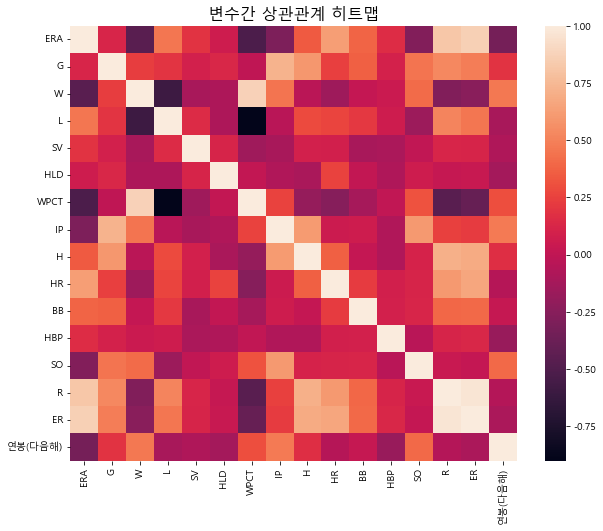

In [316]:
plt.figure(figsize = (10,8))
sns.heatmap(X_train.drop(['선수명','년도'],axis = 1).corr())
plt.title('변수간 상관관계 히트맵', size = 16)
plt.show()

- 상관관계가 높은 변수들 예시

```
1. 경기수와 승 수 : 승 수가 많다면 당연히 경기수가 많을 것이다. 양의 상관관계를 갖고 있다.
2. 승리와 승률 : 승리가 많다면 승률이 높을 것이라고 예측할 수 있다.
3. 피안타와 경기수 : 경기수가 많다면 아무리 잘 던지는 투수라고 한들 피안타수가 늘어날 수 밖에 없다.
4. 실점과 자책점 : 실점을 토대로 자책점을 계산하기에 둘의 상관관계는 1이라고 볼 수도 있을것이다.
```

- 변수간 상관계수가 높은 관계가 많이 보인다. 따라서 전부다 선형회귀분석의 변수로 쓸 것이 아니라, 차원을 축소하는것이 좋아보인다. 
- *`다중공선성 제거의 목적`*

### 다시 한 번 데이터 정리
- 년도, 연봉, 선수명은 X_train, X_test에서 빼고
- 연봉은 y_train, y_test로 설정

In [317]:
y_train = X_train['연봉(다음해)']
y_test = X_test['연봉(다음해)']

X_train.drop(['선수명','년도','연봉(다음해)'], axis = 1, inplace = True)
X_test.drop(['선수명','년도','연봉(다음해)'], axis = 1, inplace = True)

C:\Users\RYU\anaconda3\envs\ds_study\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### 선형회귀분석 모델 사용 

### 1. 모든 변수를 그대로 사용 (sklearn 모듈 사용)

In [318]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train, y_train) 

LinearRegression()

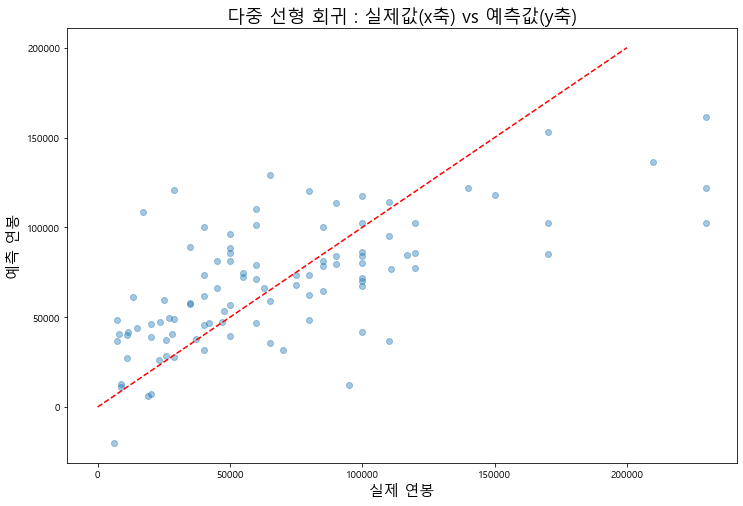

In [319]:
y_predict = mlr.predict(X_train)
plt.figure(figsize = (12,8))
plt.scatter(y_train, y_predict, alpha=0.4)
plt.plot([0,200000],[0,200000], ls = 'dashed', color = 'red')
plt.xlabel("실제 연봉", size = 15)
plt.ylabel("예측 연봉", size = 15)
plt.title("다중 선형 회귀 : 실제값(x축) vs 예측값(y축)", size = 18)
plt.show()

- 1. 상당히 고액의 연봉을 받고 있는 선수들의 대부분은 모델에 의해 연봉이 적게 추정되고있다.
- 2. 빨간 점선 선상에 있을 수록 데이터들이 잘 예측 된것인데, 이 그림을 봐서는 그렇게 잘 추정한다고 볼 수 없을 것 같다.
- 3. 실제 연봉이 매우 적음에도 예측 연봉이 높은 선수들도 있다.
    - 3-1. 이런 데이터들은 대형 신인 선수의 경우 일 수도 있겠다.(적은 연봉을 받을 때도 굉장히 좋은 성적을 유지했던)

In [320]:
print('결정계수 값 :',mlr.score(X_train,y_train))

결정계수 값 : 0.44197961394621443


In [321]:
print('회귀계수 값 :',mlr.intercept_, mlr.coef_)

회귀계수 값 : 203295.51650312933 [ -22078.64616734  -10863.20938667   11389.5706904    -2577.43334545
    8524.69549834     726.38448275 -236831.3399688      656.39108938
     254.5477524      511.36015487     479.62655504   -1072.33984758
     280.13472242    2111.52568966   -1349.52981767]


In [322]:
print('MSE : ', round(np.mean((mlr.predict(X_train) - y_train)**2),2))

MSE :  1437852612.11


- 실제로 결정계수 값이나, MSE를 봤을 때 예측값이 실제 값의 변동을 잘 설명하지 못하는 편이라고 할 수 있겠습니다.
- 연봉은 그 선수의 가치, 연차, 상황에 따라 달라지기 때문에 분석에 쓰인 데이터만으로는 정확히 예측 할 수는 없는것 같습니다.

---

---

###### 이 부분은 변수 선택을 위해 시도하려던 부분 입니다. 시간상 해결하지 못할것 같아 생략했습니다 ######

### 2. 변수 선택 - ols 모듈 이용
- from statsmodels.formula.api import ols

In [323]:
df = total_df[total_df['연봉(다음해)'].notnull()]

In [324]:
df.rename(columns = {'연봉(다음해)' : 'pay'}, inplace = True)

C:\Users\RYU\anaconda3\envs\ds_study\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [327]:
df.columns

Index(['선수명', 'ERA', 'G', 'W', 'L', 'SV', 'HLD', 'WPCT', 'IP', 'H', 'HR', 'BB',
       'HBP', 'SO', 'R', 'ER', '년도', 'pay'],
      dtype='object')

In [347]:
obj = ols('pay ~ ERA + WPCT + G:SV + IP + G:H + G:HR + G:BB + IP:SO + G:HR', data = df).fit()
obj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pay   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     4.395
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           0.000166
Time:                        17:13:02   Log-Likelihood:                -1184.6
No. Observations:                  98   AIC:                             2387.
Df Residuals:                      89   BIC:                             2410.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.121e+05   1.08e+05     -1.040      0.301   -3.26e+05    1.02e+05
ERA        -7580.6201   1.21e+04     -0.628      0.531   -3.16e+04    1.64e+04
WPCT         3.81e+04   4.28e+04      0.890      0.376    -4.7e+04    1.23e+05
G:SV         156.7946    944.783      0.166      0.869   -1720.468    2034.057
IP          1098.7976    830.685      1.323      0.189    -551.756    2749.352
G:H           -5.5948     11.236     -0.498      0.620     -27.921      16.731
G:HR           6.8054     38.107      0.179      0.859     -68.912      82.523
G:BB           2.7258     11.730      0.232      0.817     -20.581      26.032
IP:SO          0.8703      1.316      0.662      0.510      -1.744       3.484
==============================================================================
Omnibus:                       23.496   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.600
Skew:                           1.092   Prob(JB):                     3.07e-08
Kurtosis:                       4.924   Cond. No.                     5.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

---

# 문제 3
- 이제 2번의 데이터를 기준으로 최동원의 성적이라면 연봉이 어떨지 예측하시오. 여기서 여러분들은 어쩌면 많은 고민을 해야하고, 다시 1번 문제로 돌아갈 수도 있습니다.

- 위에서 사용했던 (모든 변수를 포함한) 모델인 mlr에 최동원 선수의 데이터를 적합해 예측치를 살펴보겠습니다.

In [352]:
choi = pd.read_csv('../data/최동원.txt', sep = '\t', encoding = 'cp949')
choi.rename(columns = {'HB':'HBP'}, inplace = True)
choi

,연도,팀명,ERA,G,CG,SHO,W,L,SV,HLD,WPCT,TBF,IP,H,HR,BB,HBP,SO,R,ER
0,1983,롯데,2.89,38,16,1,9,16,4,0,0.360,863,208 2/3,202,17,51,8,148,89,67
1,1984,롯데,2.40,51,14,1,27,13,6,0,0.675,1132,284 2/3,228,18,68,14,223,91,76
2,1985,롯데,1.92,42,14,4,20,9,8,0,0.690,865,225,170,7,41,8,161,60,48
3,1986,롯데,1.55,39,17,4,19,14,2,0,0.576,1039,267,204,7,55,6,208,60,46
4,1987,롯데,2.81,32,15,4,14,12,2,0,0.538,920,224,218,6,61,7,163,80,70
5,1988,롯데,2.05,16,3,1,7,3,3,0,0.700,349,83 1/3,77,4,24,1,83,24,19


In [356]:
for idx,row in choi.iterrows():
    choi.loc[idx,'IP'] = round(eval('+'.join(row['IP'].split(' '))),2)

choi

,연도,팀명,ERA,G,CG,SHO,W,L,SV,HLD,WPCT,TBF,IP,H,HR,BB,HBP,SO,R,ER
0,1983,롯데,2.89,38,16,1,9,16,4,0,0.360,863,208.67,202,17,51,8,148,89,67
1,1984,롯데,2.40,51,14,1,27,13,6,0,0.675,1132,284.67,228,18,68,14,223,91,76
2,1985,롯데,1.92,42,14,4,20,9,8,0,0.690,865,225,170,7,41,8,161,60,48
3,1986,롯데,1.55,39,17,4,19,14,2,0,0.576,1039,267,204,7,55,6,208,60,46
4,1987,롯데,2.81,32,15,4,14,12,2,0,0.538,920,224,218,6,61,7,163,80,70
5,1988,롯데,2.05,16,3,1,7,3,3,0,0.700,349,83.33,77,4,24,1,83,24,19


In [362]:
choi['예상연봉(다음해)'] = mlr.predict(choi[X_train.columns])
choi['예상연봉(다음해)'] = round(choi['예상연봉(다음해)'],2)
choi

,연도,팀명,ERA,G,CG,SHO,W,L,SV,HLD,...,TBF,IP,H,HR,BB,HBP,SO,R,ER,예상연봉(다음해)
0,1983,롯데,2.89,38,16,1,9,16,4,0,...,863,208.67,202,17,51,8,148,89,67,88723.33
1,1984,롯데,2.40,51,14,1,27,13,6,0,...,1132,284.67,228,18,68,14,223,91,76,185334.56
2,1985,롯데,1.92,42,14,4,20,9,8,0,...,865,225,170,7,41,8,161,60,48,126670.58
3,1986,롯데,1.55,39,17,4,19,14,2,0,...,1039,267,204,7,55,6,208,60,46,179951.06
4,1987,롯데,2.81,32,15,4,14,12,2,0,...,920,224,218,6,61,7,163,80,70,159249.68
5,1988,롯데,2.05,16,3,1,7,3,3,0,...,349,83.33,77,4,24,1,83,24,19,51077.90


- 예전 야구를 잘 알지는 못하지만, 데이터를 탐색하며 여러 자료를 함께 검색해 본 결과 최동원 선수는 정말 뛰어난 선수였음은 틀림없는것 같습니다.

- 위에서 잠깐 언급했던 개인수상 내역을 살펴보겠습니다.

In [363]:
pd.read_csv('../data/개인수상.txt', sep = '\t', encoding = 'cp949')

,연도,KBO MVP,KBO 신인상,KBO 올스타전 MVP,한국시리즈 MVP
0,2020,"로하스(KT,외야수)","소형준(KT,투수)","양의지(NC,포수)","양의지(NC,포수)"
1,2019,"린드블럼(두산,투수)","정우영(LG,투수)","한동민(SK,외야수)","오재일(두산,내야수)"
2,2018,"김재환(두산,외야수)","강백호(KT,외야수)","김하성(넥센,내야수)","한동민(SK,외야수)"
3,2017,"양현종(KIA,투수)","이정후(넥센,내야수)","최정(SK,내야수)","양현종(KIA,투수)"
4,2016,"니퍼트(두산,투수)","신재영(넥센,투수)","민병헌(두산,외야수)","양의지(두산,포수)"
5,2015,"테임즈(NC,내야수)","구자욱(삼성,내야수)","강민호(롯데,포수)","정수빈(두산,외야수)"
6,1987,"장효조(삼성,외야수)","이정훈(빙그레,외야수)","김종모(해태,외야수)","김준환(해태,외야수)"
7,1986,"선동열(해태,투수)","김건우(MBC,투수)","김무종(해태,포수)","김정수(해태,투수)"
8,1985,"김성한(해태,내야수)","이순철(해태,내야수)","김시진(삼성,투수)",해당자 없음
9,1984,"최동원(롯데,투수)","윤석환(OB,투수)","김용희(롯데,내야수)","유두열(롯데,외야수)"


In [364]:
Golden_glove

,연도,투수,팀
0,2020년,알칸타라,두산
1,2019년,린드블럼,두산
2,2018년,린드블럼,두산
3,2017년,양현종,KIA
4,2016년,니퍼트,두산
5,2015년,해커,NC
6,1988년,선동열,해태
7,1987년,김시진,삼성
8,1986년,선동열,해태
9,1985년,김시진,삼성


- 최동원 선수는 1984년 엄청난 활약을 펼치며 KBO 정규리그 MVP, 골든글러브를 수상하고 롯데를 우승으로 이끌었습니다. (한국시리즈 나홀로 4승 우승)
    - 그럼에도 한국시리즈 MVP는 유두열선수인것을 보면 신기하기도 하면서, 유두열 선수는 얼마나 큰 활약을 했을지 궁금하기도 합니다.
    
    
- 그 활약이 여러 투수 지표에도 나타나며 우리가 사용한 모델은 다음 해 예상 연봉을 18억 5천만원가량으로 예측하기도 했습니다.


- 심지어 우리의 모델은 흔히 탑클래스라고 부르는 선수들의 연봉은 적게 추정하는 경향이 있었기에 실제 연봉은 20억을 웃돌지 않았을까 합니다.

- 그럼 실제로 현 시대에서 전성기 기준 최동원 선수와 비슷한 연봉을 받거나 그보다 많이 받는 투수는 누가 있을지 확인해보겠습니다.
    - 2015~2020년 연봉 시세 기준

In [372]:
total_df[total_df['연봉(다음해)'] >= 185000]

,선수명,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,년도,연봉(다음해)
149,니퍼트,2.95,28,22,3,0,0,0.880,167.67,151,15,57,9,142,61,55,2016,210000.0
170,양현종,3.44,31,20,6,0,0,0.769,193.33,209,17,45,0,158,88,74,2017,230000.0
192,양현종,4.15,29,13,11,0,0,0.542,184.33,199,21,43,2,152,88,85,2018,230000.0
210,양현종,2.29,29,16,8,0,0,0.667,184.67,165,6,33,2,163,56,47,2019,230000.0


- 최전성기 시절 지표로 판단한 연봉 기준, 최동원 선수보다 많은 연봉을 받는 선수는 단 두 선수입니다.


- 그 중 한국인 선수로는 최근에 메이저리그에 진출해 활약하고 있는 양현종 선수밖에 없습니다.
- 3년 연속 좋은 폼을 유지하며 상당히 고액의 연봉을 수급했던 것으로 보여집니다.


- 16년도의 니퍼트 선수 또한 활약이 대단했던 것으로 보여집니다.

**느낀점**

```
 무엇보다 스포츠에 관심이 많아서 이번 과제를 재밌게 진행 한 것이 가장 기억에 남습니다.
 
 다만 아쉬운 점이 있다면, 시간의 한계로 분석을 마음껏 해보지 못한 점이 아쉬움에 남는 과제였습니다. 복습하고 반복적인 작업을 통해 효율성을 극대화 시키고 시간을 줄일 수 있어야 한다고 느꼈습니다.
 또한, 과거 선수들의 연봉 데이터를 구하지 못하여 결국 과거 선수들의 지표는 사용하지 못한점이 무엇보다 가장 큰 아쉬움이었습니다. (사실상 현재 선수들의 데이터 + 최동원 선수의 과거 데이터만 이용한 것.)

 개인적으로는 스포츠에서의 여러 지표는 상관관계가 높고, 차원이 크기 때문에 주성분분석 혹은 인자분석을 활용하여 차원축소를 하면 데이터를 더 잘 다룰 수 있고 남에게 설명하기 더 좋다고 생각했었는데, 이를 확인해 볼 수 있는 좋은 과제인것같아서 이번 기회를 토대로 추가적인 공부와 프로젝트를 수행하면 더 재밌고 궁금증을 해결 할 수 있을거라고 생각합니다.

긴 프로젝트 과정 끝까지 읽어주셔서 감사합니다!
```